# Setup and Imports

In [1]:
!nvidia-smi

Sun Jan 19 20:40:14 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [28]:
!pip install -q kaggle torch_snippets

In [42]:
import os
# import torch
# import numpy as np, cv2, pandas as pd, glob, time
# import matplotlib.pyplot as plt
# import torch.nn as nn
# from torch import optim
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# import torchvision
# from torchvision import transforms, models, datasets
from torch_snippets import *
from torchvision import transforms as T
from torch_snippets.torch_loader import Report
from sklearn.model_selection import train_test_split

In [4]:
!kaggle datasets download iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
100% 673M/675M [00:32<00:00, 24.9MB/s]
100% 675M/675M [00:32<00:00, 22.0MB/s]


In [8]:
!unzip -qq cell-images-for-detecting-malaria.zip

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Preprocessing

In [32]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

In [33]:
train_tfms = T.Compose([
  T.ToPILImage(),
  T.Resize(128),
  T.CenterCrop(128),
  T.ColorJitter(brightness=(0.95,1.05),
  contrast=(0.95,1.05),
  saturation=(0.95,1.05),
  hue=0.05),
  T.RandomAffine(5, translate=(0.01,0.1)),
  T.ToTensor(),
  T.Normalize(mean=[0.5, 0.5, 0.5],
  std=[0.5, 0.5, 0.5]),
 ])

In [34]:
val_tfms = T.Compose([
  T.ToPILImage(),
  T.Resize(128),
  T.CenterCrop(128),
  T.ToTensor(),
  T.Normalize(mean=[0.5, 0.5, 0.5],
  std=[0.5, 0.5, 0.5]),
 ])

In [35]:
class MalariaImages(Dataset):

  def __init__(self, files, transform=None):
    self.files = files
    self.transform = transform
    logger.info(len(self))

  def __len__(self):
    return len(self.files)

  def __getitem__(self, ix):
    fpath = self.files[ix]
    clss = fname(parent(fpath))
    img = read(fpath, 1)

    return img, clss

  def choose(self):
    return self[randint(len(self))]

  def collate_fn(self, batch):
    _imgs, classes = list(zip(*batch))

    if self.transform:
      imgs = [self.transform(img)[None] for img in _imgs]

    classes = [torch.tensor([id2int[clss]]) for clss in classes]
    imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]

    return imgs, classes, _imgs

In [36]:
all_files = Glob('cell_images/*/*.png')

np.random.seed(10)

np.random.shuffle(all_files)

trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = MalariaImages(trn_files, transform=train_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)

trn_dl = DataLoader(trn_ds, 32, shuffle=True,
                    collate_fn=trn_ds.collate_fn)

val_dl = DataLoader(val_ds, 32, shuffle=False,
                    collate_fn=val_ds.collate_fn)

[01/19/25 20:54:07] INFO     20668                                                                                                ]8;id=863508;file://<ipython-input-35-19505af7a1f5>:6\<ipython-input-35-19505af7a1f5>]8;;\:]8;id=207987;file://<ipython-input-35-19505af7a1f5>:6#__init__:6\__init__:6]8;;\

                    INFO     6890                                                                                                 ]8;id=961045;file://<ipython-input-35-19505af7a1f5>:6\<ipython-input-35-19505af7a1f5>]8;;\:]8;id=852283;file://<ipython-input-35-19505af7a1f5>:6#__init__:6\__init__:6]8;;\

In [37]:
def convBlock(ni, no):
  return nn.Sequential(
    nn.Dropout(0.2),
    nn.Conv2d(ni, no, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2),
  )

In [38]:
class MalariaClassifier(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
      convBlock(3, 64),
      convBlock(64, 64),
      convBlock(64, 128),
      convBlock(128, 256),
      convBlock(256, 512),
      convBlock(512, 64),
      nn.Flatten(),
      nn.Linear(256, 256),
      nn.Dropout(0.2),
      nn.ReLU(inplace=True),
      nn.Linear(256, len(id2int))
    )

    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, x):
    return self.model(x)

  def compute_metrics(self, preds, targets):
    loss = self.loss_fn(preds, targets)
    acc =(torch.max(preds, 1)[1]==targets).float().mean()

    return loss, acc

# Training and Validation

In [39]:
def train_batch(model, data, optimizer, criterion):
  model.train()
  ims, labels, _ = data
  _preds = model(ims)
  optimizer.zero_grad()
  loss, acc = criterion(_preds, labels)
  loss.backward()
  optimizer.step()

  return loss.item(), acc.item()

In [40]:
@torch.no_grad()
def validate_batch(model, data, criterion):
  model.eval()
  ims, labels, _ = data
  _preds = model(ims)
  loss, acc = criterion(_preds, labels)

  return loss.item(), acc.item()

In [44]:
import tqdm

model = MalariaClassifier().to(device)

criterion = model.compute_metrics

optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 2

log = Report(n_epochs)

for ex in range(n_epochs):
  N = len(trn_dl)

  for bx, data in tqdm.tqdm_notebook(enumerate(trn_dl)):
    loss, acc = train_batch(model, data, optimizer, criterion)
    log.record(ex+(bx+1)/N,trn_loss=loss,trn_acc=acc, end='\r')

  N = len(val_dl)

  for bx, data in tqdm.tqdm_notebook(enumerate(val_dl)):
    loss, acc = validate_batch(model, data, criterion)
    log.record(ex+(bx+1)/N,val_loss=loss,val_acc=acc, end='\r')

  log.report_avgs(ex+1)

<ipython-input-44-e7bd0a90724e>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bx, data in tqdm.tqdm_notebook(enumerate(trn_dl)):


0it [00:00, ?it/s]

EPOCH: 1.000  trn_loss: 0.072  trn_acc: 1.000  (119.51s - 119.51s remaining)

<ipython-input-44-e7bd0a90724e>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bx, data in tqdm.tqdm_notebook(enumerate(val_dl)):


0it [00:00, ?it/s]

EPOCH: 1.000  val_loss: 0.147  val_acc: 0.955  trn_acc: 0.909  trn_loss: 0.240  (137.09s - 137.09s remaining)


0it [00:00, ?it/s]

EPOCH: 2.000  trn_loss: 0.142  trn_acc: 0.964  (252.59s - 0.00s remaining)

0it [00:00, ?it/s]

EPOCH: 2.000  val_loss: 0.187  val_acc: 0.940  trn_acc: 0.943  trn_loss: 0.172  (270.12s - 0.00s remaining)


In [45]:
im2fmap = nn.Sequential(*(list(model.model[:5].children())+ \
                          list(model.model[5][:2].children())))

In [53]:
def im2gradCAM(x):
  model.eval()

  logits = model(x)

  heatmaps = []

  activations = im2fmap(x)

  # print(activations.shape)

  pred = logits.max(-1)[-1]

  # Getting the model's prediction
  model.zero_grad()

  # Computing gradients with respect to
  # model's most confident logit
  logits[0,pred].backward(retain_graph=True)

  # Getting the gradients at the required featuremap location
  # and take the avg gradient for every featuremap
  pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))

  # Multiplying each activation map with
  # Corresponding gradient average
  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pooled_grads[i]

  # Taking the mean of all weighted activation maps
  # (that has been weighted by avg. grad at each fmap)
  heatmap =torch.mean(activations, dim=1)[0].cpu().detach()

  return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [54]:
SZ = 128

def upsampleHeatmap(map, img):
  m,M = map.min(), map.max()
  map = 255 * ((map-m) / (M-m))
  map = np.uint8(map)
  map = cv2.resize(map, (SZ,SZ))
  map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
  map = np.uint8(map)
  map = np.uint8(map*0.7 + img*0.3)

  return map

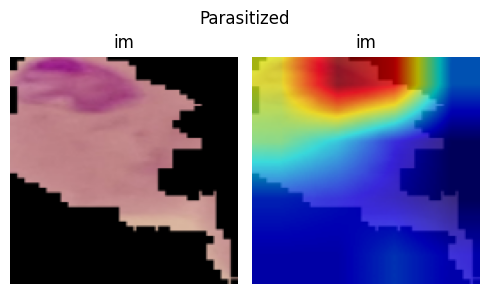

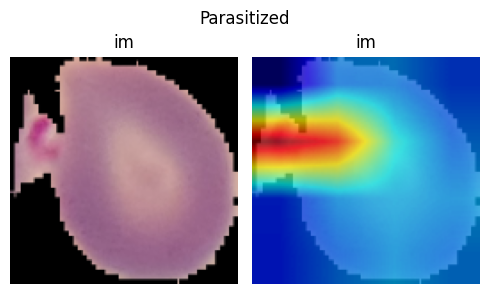

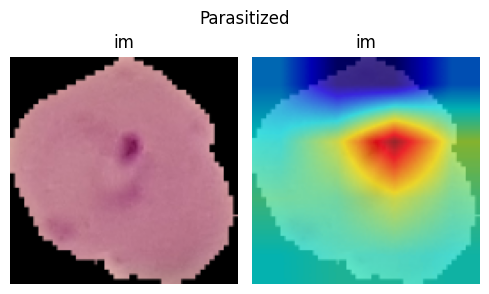

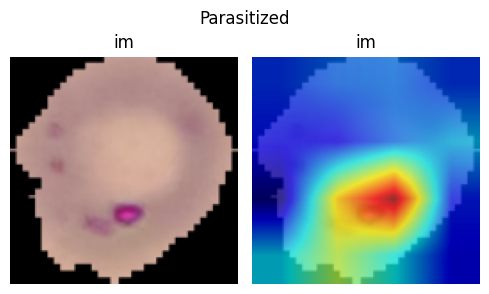

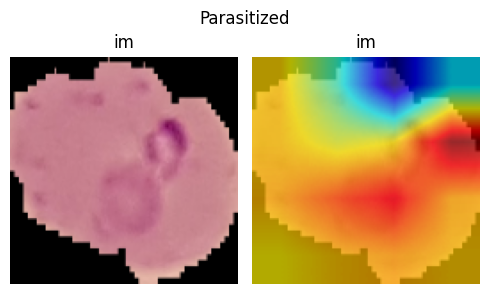

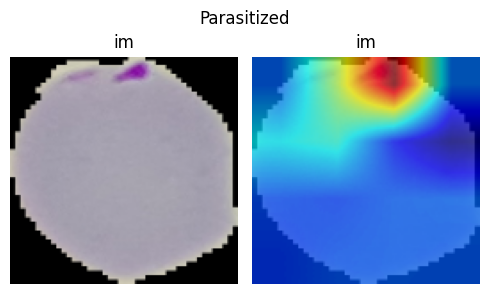

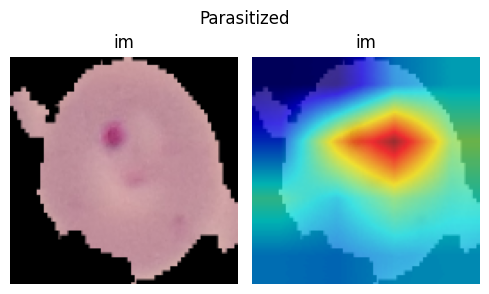

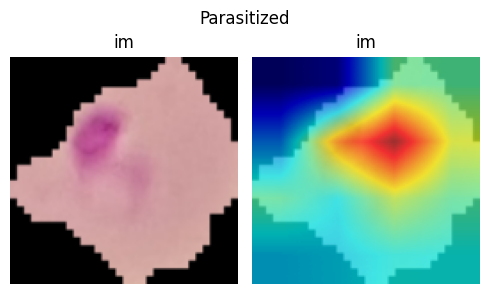

In [55]:
N = 20

_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
  image = resize(z[i], SZ)
  heatmap, pred = im2gradCAM(x[i:i+1])

  if(pred=='Uninfected'):
    continue

  heatmap = upsampleHeatmap(heatmap, image)

  subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)